# Order effects

Experiment 1 found order effects in the image condition: the first image block was much more variable for subjects than on the second image block and for all word blocks. We reason that these order effects drive an interaction between `question` and `modality`. Here, we simulate these order effects to 1) determine if an how order effects influence the `question * modality` relationship and 2) review and revise our mixed linear model and 3) set up additional power analyses. 

In [ ]:
# If you have not installed `wiscs` locally, run this cell
!pip install git+https://github.com/w-decker/wiscs.git --quiet # REQUIRED FOR THIS NOTEBOOK
!pip install git+https://github.com/w-decker/rinterface.git --quiet # REQUIRED FOR THIS NOTEBOOK

In [1]:
# always run this cell, no matter which method you choose
import wiscs
from wiscs.simulate import DataGenerator
from wiscs.formula import Formula

import rinterface.rinterface as R
from rinterface.utils import to_r

import numpy as np
import pandas as pd

## Generate base dataset (without interaction)

In [2]:
n_subject = 180
n_item = 30
n_question = 2
word_task = np.array([100, 100])
hyp = "shared"
if hyp == "shared":
    image_task = np.array([100, 100])
else:
    image_task = np.array([100, 105])

re_formula = Formula("(1 + question | subject) + (1 + question | item)")
question_sd = [10, 12, 15, 18, 11] # must be n_q - 1
params = {'word.perceptual': 100, 'image.perceptual': 95, 'word.conceptual': 100, 'image.conceptual': 100, 'word.task': word_task, 'image.task': image_task,
        # noise parameters     
        'sd.item': 40,     'sd.question': question_sd[:n_question-1],    'sd.subject': 35,       "sd.modality": 30, "sd.error": 50, "sd.re_formula": str(re_formula),
        # correlations among random effects    
        "corr.subject": np.eye(n_question), 'corr.item':np.eye(n_question),
        # design parameters
        'n.subject': n_subject, 'n.question': n_question, 'n.item': n_item
}
wiscs.set_params(params, verbose=False)

DG = DataGenerator()
DG.fit_transform(seed=2027, verbose=False)

In [3]:
# convert to pandas dataframe and save
df = DG.to_pandas()
df.to_csv("wiscs_data.csv", index=False)
df.head(15)

,subject,rt,question,item,modality
0,0,260.720790,0,0,image
1,0,276.702877,0,1,image
2,0,307.233451,0,2,image
3,0,243.875058,0,3,image
4,0,314.533726,0,4,image
5,0,402.140082,0,5,image
6,0,282.735961,0,6,image
7,0,304.564423,0,7,image
8,0,440.048434,0,8,image
9,0,222.232460,0,9,image


## What do no order effects look like?

Below is a subset of subject's reaction times _without_ order effects. As you can see, there is no interaction of question and modality. 

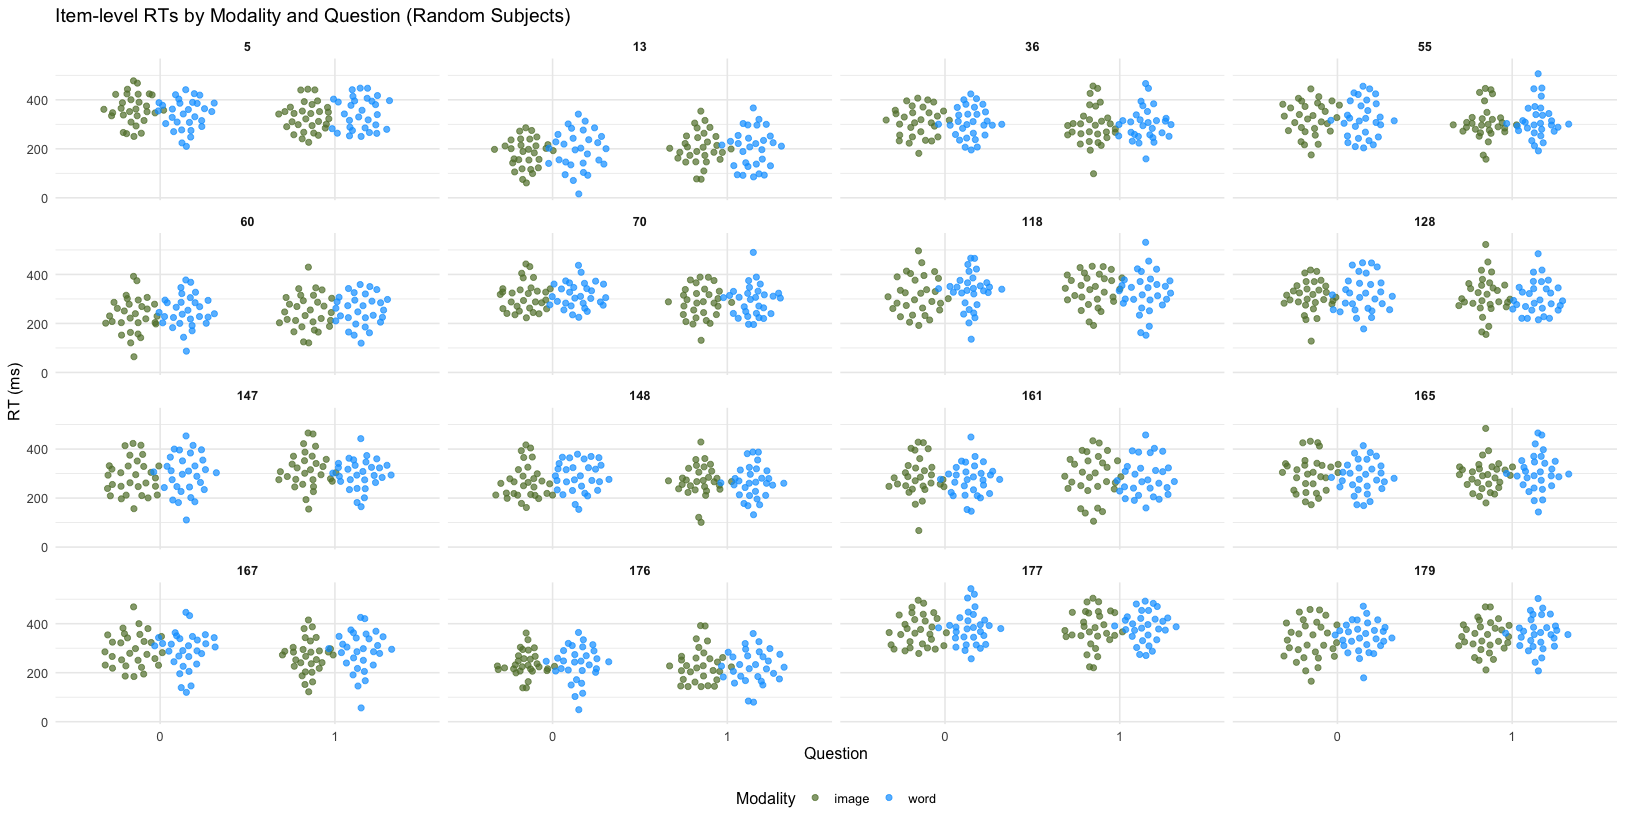

## What's next? 

Currently, the `wiscs` framework is does not have the flexibility to simulate order effects, so we will do it post-hoc on our simulated dataset!

## How are order effects generated?

Order effects will simply be a 1) shift and 2) greater spread (more noise) of the distribution of RTs for the image condition for the question subject's saw first. Half of participants saw `0` first and the other half started with `1`. Not all subjects will have order effects, as seen in Exp1.

In [4]:
df2 = df.copy()
np.random.seed(44)
subjects = df2['subject'].unique()
tags = np.random.choice([0, 1], size=len(subjects))
subject_tags = dict(zip(subjects, tags))
df2['tag'] = df2['subject'].map(subject_tags)
df2['qorder'] = np.where(df2['question'] == df2['tag'], 0, 1)

# add shift

def shift_rt(row, shift=300, noise_sd=50):
    if row['modality'] == 'image' and row['question'] == row['tag']:
        return row['rt'] + shift + np.random.normal(0, noise_sd)
    else:
        return row['rt']

# add order effects
df2['rt'] = df2.apply(shift_rt, axis=1)

In [5]:
df2.to_csv("wiscs_data_ordere.csv", index=False)

## Is there an interaction now?

In [6]:
code = f"""df <- {to_r(df2)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)
    library(tinytable, quietly = TRUE)
    library(tidyverse, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + (1 + question + modality | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    swith <- summary(with)
    swith

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question + (1 + question + modality | subject) +  
    (1 + question | item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 259053.3  259165.0 -129512.7  259025.3     21586 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7685 -0.8083 -0.0732  0.7959  3.5361 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr       
 subject  (Intercept)  6517.565  80.731             
          question1   23058.177 151.849  -0.90      
          modality1       1.141   1.068  -0.97  0.98
 item     (Intercept)  2026.116  45.012             
          question1      42.060   6.485  0.40       
 Residual              8826.514  93.950             
Number of obs: 21600, groups:  subject, 180; item, 30

Fixed effects:
                     Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           371.148   

## Running linear models

#### 1. Is there a main effect of `qorder`?
#### 2. Is there an interaction of `qorder` and `modality`?
#### 3. Does inclusion of these predictors increase model fit?


## Is there a main effect of `qorder` and is there an interaction of `qorder` and `modality`?

In [7]:
code = f"""df <- {to_r(df2)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + qorder*modality + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    summary(with)

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question + qorder * modality + (1 + question |  
    subject) + (1 + question | item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 236026.0  236129.8 -118000.0  236000.0     21587 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4941 -0.6452 -0.0067  0.6456  4.7253 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 subject  (Intercept) 1368.50  36.993        
          question1     87.62   9.360   -0.12
 item     (Intercept) 2042.04  45.189        
          question1     71.56   8.459   0.26 
 Residual             3100.27  55.680        
Number of obs: 21600, groups:  subject, 180; item, 30

Fixed effects:
                      Estimate Std. Error         df  t value Pr(>|t|)    
(Intercept)           448.0902     8.7309    37.2098   51.322   <2e-16 ***
modality1             294.7768     1.317

## Does inclusion of `qorder` improve model fit?

In [8]:
code = f"""df <- {to_r(df2)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + qorder * modality + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    without <- lmer(rt ~ modality * question + (1 | subject) + (1 | item), data = df, REML = FALSE, control = control) # nolint

    anova(with, without, type = 3) # nolint

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



Data: df
Models:
without: rt ~ modality * question + (1 | subject) + (1 | item)
with: rt ~ modality * question + qorder * modality + (1 + question | subject) + (1 + question | item)
        npar    AIC    BIC  logLik -2*log(L) Chisq Df Pr(>Chisq)    
without    7 269088 269144 -134537    269074                        
with      13 236026 236130 -118000    236000 33074  6  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Only generating order effects for a proportion of subjects

In [9]:
df3 = df.copy()
np.random.seed(44)
subjects = df3['subject'].unique()
tags = np.random.choice([0, 1], size=len(subjects))
subject_tags = dict(zip(subjects, tags))
df3['tag'] = df3['subject'].map(subject_tags)
df3['qorder'] = np.where(df3['question'] == df2['tag'], 0, 1)


# subset subjects to receive the order effect
proportion_with_effect = 0.35
n_effect = int(proportion_with_effect * len(subjects))
np.random.seed(99)
subjects_with_effect = np.random.choice(subjects, size=n_effect, replace=False)
subjects_with_effect = set(subjects_with_effect)

# function to apply order effect only to some participants
def shift_rt(row, shift=300, noise_sd=50):
    if (
        row['subject'] in subjects_with_effect and
        row['modality'] == 'image' and
        row['question'] == row['tag']
    ):
        return row['rt'] + shift + np.random.normal(0, noise_sd)
    else:
        return row['rt']

# Apply order effect
df3['rt'] = df3.apply(shift_rt, axis=1)
df3.to_csv("wiscs_data_ordere2.csv", index=False)

## Does _this_ force an interaction?

In [10]:
code = f"""

    df <- {to_r(df3)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)
    library(tinytable, quietly = TRUE)
    library(tidyverse, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + (1 + question + modality | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    swith <- summary(with)
    swith

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question + (1 + question + modality | subject) +  
    (1 + question | item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 245963.8  246075.6 -122967.9  245935.8     21586 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5374 -0.6399 -0.0147  0.6189  4.3904 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 subject  (Intercept) 4827.34  69.479              
          question1   7797.85  88.305   -0.66      
          modality1   5229.04  72.312    0.61 -0.11
 item     (Intercept) 2073.21  45.532              
          question1     69.83   8.357   0.22       
 Residual             4658.04  68.250              
Number of obs: 21600, groups:  subject, 180; item, 30

Fixed effects:
                     Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           326.927      9.81

In [11]:
df4 = df3.copy()

# randomly remove 12 subjects
np.random.seed(44)
subjects = df4['subject'].unique()
subjects_to_remove = np.random.choice(subjects, size=12, replace=False)
df4 = df4[~df4['subject'].isin(subjects_to_remove)]
df4.to_csv("wiscs_data_ordere3.csv", index=False)

## Accounting for excluded data

In [12]:
df5 = df3.copy()

# add a new column 'included'
df5['included'] = (~df5['subject'].isin(subjects_to_remove)).astype(int)

# save the updated dataframe to a CSV file
df5.to_csv("wiscs_data_ordere4.csv", index=False)

df5.head(15)

,subject,rt,question,item,modality,tag,qorder,included
0,0,260.720790,0,0,image,0,0,1
1,0,276.702877,0,1,image,0,0,1
2,0,307.233451,0,2,image,0,0,1
3,0,243.875058,0,3,image,0,0,1
4,0,314.533726,0,4,image,0,0,1
5,0,402.140082,0,5,image,0,0,1
6,0,282.735961,0,6,image,0,0,1
7,0,304.564423,0,7,image,0,0,1
8,0,440.048434,0,8,image,0,0,1
9,0,222.232460,0,9,image,0,0,1


## Is the interaction suppressed?

In [36]:
code = f"""

    df <- {to_r(df5)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)
    library(tinytable, quietly = TRUE)
    library(tidyverse, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    df$included <- as.factor(df$included)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question * included + qorder*modality + (1 + question + modality | subject) + (1 + question + modality | item), data = df, REML = FALSE, control = control) # nolint

    swith <- summary(with)
    swith

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question * included + qorder * modality + (1 +  
    question + modality | subject) + (1 + question + modality |      item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 242546.3  242729.9 -121250.2  242500.3     21577 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4517 -0.6842 -0.0172  0.6516  4.3235 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 subject  (Intercept) 4063.212 63.743              
          question1   4903.078 70.022   -0.57      
          modality1   5251.971 72.470    0.62 -0.06
 item     (Intercept) 2075.008 45.552              
          question1     73.629  8.581    0.21      
          modality1      1.226  1.107   -0.85  0.34
 Residual             3970.255 63.010              
Number of obs: 21600, groups:  subject, 180; item, 30

Fixed effects:
            

## Adding class imbalances in the other direction 

In [18]:
# generate a copy of the original dataframe
df6 = df.copy()
# randomly remove 12 subjects
np.random.seed(44)
subjects = df6['subject'].unique()
subjects_to_remove = np.random.choice(subjects, size=12, replace=False)
df6 = df6[~df6['subject'].isin(subjects_to_remove)]
tags = np.random.choice([0, 1], size=len(subjects))
subject_tags = dict(zip(subjects, tags))
df6['tag'] = df6['subject'].map(subject_tags)
df6['qorder'] = np.where(df6['question'] == df6['tag'], 0, 1)
df6.to_csv("wiscs_data_ordere5.csv", index=False)


In [19]:
df6.head(15)

,subject,rt,question,item,modality,tag,qorder
0,0,260.720790,0,0,image,1,1
1,0,276.702877,0,1,image,1,1
2,0,307.233451,0,2,image,1,1
3,0,243.875058,0,3,image,1,1
4,0,314.533726,0,4,image,1,1
5,0,402.140082,0,5,image,1,1
6,0,282.735961,0,6,image,1,1
7,0,304.564423,0,7,image,1,1
8,0,440.048434,0,8,image,1,1
9,0,222.232460,0,9,image,1,1


In [20]:
# stats
code = f"""

    df <- {to_r(df6)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)
    library(tinytable, quietly = TRUE)
    library(tidyverse, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + (1 + question + modality | subject) + (1 + question + modality | item), data = df, REML = FALSE, control = control) # nolint

    swith <- summary(with)
    swith

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question + (1 + question + modality | subject) +  
    (1 + question + modality | item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 215933.9  216068.4 -107949.9  215899.9     20143 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7801 -0.6649 -0.0023  0.6599  3.9842 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr       
 subject  (Intercept) 1313.0917 36.2366             
          question1     76.9750  8.7735  -0.01      
          modality1      4.7146  2.1713  -0.14  0.99
 item     (Intercept) 2090.7990 45.7253             
          question1     81.0987  9.0055   0.17      
          modality1      0.8042  0.8968  -0.59  0.70
 Residual             2487.4323 49.8742             
Number of obs: 20160, groups:  subject, 168; item, 30

Fixed effects:
                      Estimate Std. Erro

In [24]:
# add order effects
df7 = df6.copy()

# subset subjects to receive  order effect
proportion_with_effect = 0.35
n_effect = int(proportion_with_effect * len(subjects))
np.random.seed(99)
subjects_with_effect = np.random.choice(subjects, size=n_effect, replace=False)
subjects_with_effect = set(subjects_with_effect)

# function to apply order effect only to some participants
def shift_rt(row, shift=300, noise_sd=50):
    if (
        row['subject'] in subjects_with_effect and
        row['modality'] == 'image' and
        row['question'] == row['tag']
    ):
        return row['rt'] + shift + np.random.normal(0, noise_sd)
    else:
        return row['rt']

# Apply order effect
df7['rt'] = df7.apply(shift_rt, axis=1)
df7.to_csv("wiscs_data_ordere6.csv", index=False)

In [25]:
# stats
code = f"""

    df <- {to_r(df7)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)
    library(tinytable, quietly = TRUE)
    library(tidyverse, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + (1 + question + modality | subject) + (1 + question + modality | item), data = df, REML = FALSE, control = control) # nolint

    swith <- summary(with)
    swith

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question + (1 + question + modality | subject) +  
    (1 + question + modality | item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 229646.7  229781.2 -114806.4  229612.7     20143 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8098 -0.6349 -0.0161  0.6234  4.4668 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 subject  (Intercept) 4053.797 63.669              
          question1   7924.069 89.017   -0.61      
          modality1   5237.680 72.372    0.46  0.15
 item     (Intercept) 2090.657 45.724              
          question1     77.680  8.814    0.15      
          modality1      1.104  1.051   -0.64  0.66
 Residual             4672.642 68.357              
Number of obs: 20160, groups:  subject, 168; item, 30

Fixed effects:
                     Estimate Std. Error        

In [28]:
# adding qorder
# stats
code = f"""

    df <- {to_r(df7)}
    # load libraries
    library(lme4, quietly = TRUE)
    library(lmerTest, quietly = TRUE)
    library(tinytable, quietly = TRUE)
    library(tidyverse, quietly = TRUE)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    df$qorder <- as.factor(df$qorder)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality * question + qorder*modality + (1 + question + modality | subject) + (1 + question + modality | item), data = df, REML = FALSE, control = control) # nolint

    swith <- summary(with)
    swith

"""
R(code)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality * question + qorder * modality + (1 + question +  
    modality | subject) + (1 + question + modality | item)
   Data: df
Control: control

      AIC       BIC    logLik -2*log(L)  df.resid 
 226411.1  226561.4 -113186.6  226373.1     20141 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7053 -0.6718 -0.0152  0.6640  4.4484 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 subject  (Intercept) 3641.824 60.348              
          question1   5189.994 72.042   -0.54      
          modality1   5260.963 72.532    0.52  0.13
 item     (Intercept) 2092.772 45.747              
          question1     81.678  9.038    0.15      
          modality1      1.148  1.071   -0.63  0.68
 Residual             3974.701 63.045              
Number of obs: 20160, groups:  subject, 168; item, 30

Fixed effects:
                      Estima